<a href="https://colab.research.google.com/github/melibrun/machine-learning-/blob/main/%D0%98%D0%B2%D0%B0%D0%BD%D0%BE%D0%B2%D0%B0_%D0%A1%D0%B0%D1%88%D0%B0_%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_14_%D0%9C%D0%B5%D1%85%D0%B0%D0%BD%D0%B8%D0%B7%D0%BC%D1%8B_%D0%B2%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B8_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80%D1%8B_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нахождение лекарств, заболеваний и взаимосвязи между ними

BioBERT - трансформер, предобученный на корпусе медицинских текстов. 
Поставим два замечательных пакета для работы с трансформерами

In [ ]:
!pip install -q transformers
!pip install -q simpletransformers

     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 182 kB 72.1 MB/s 
     |████████████████████████████████| 7.6 MB 61.8 MB/s 
     |████████████████████████████████| 250 kB 5.3 MB/s 
     |████████████████████████████████| 1.9 MB 58.9 MB/s 
     |████████████████████████████████| 9.2 MB 56.6 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 452 kB 75.8 MB/s 
     |████████████████████████████████| 174 kB 19.4 MB/s 
     |████████████████████████████████| 182 kB 71.8 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 173 kB 73.6 MB/s 
     |████████████████████████████████| 168 kB 72.2 MB/s 
     |████████████████████████████████| 168 kB 81.9 MB/s 
     |████████████████████████████████| 166 kB 65.8 MB/s 
     |████████████████████████████████| 166 kB 82.2 MB/s 
     |██████████████

Загрузим данные с гитхаба. Это данные датасета BC5CDR - текстового датасета, в котором проаннотированы слова/словосочетания, относящиеся к химическим веществам, заболеваниям и взаимосвязи между ними. 

Задачей является уметь предсказывать эти слова (помечая их тегами I и B,         [подробнее](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) )

In [ ]:
import urllib.request
from pathlib import Path

def download_file(url, output_file):
  Path(output_file).parent.mkdir(parents=True, exist_ok=True)
  urllib.request.urlretrieve (url, output_file)

download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/train.txt', '/content/data/train.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/test.txt', '/content/data/test.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/dev.txt', '/content/data/dev.txt')

И напишем код для их перформатирования 

In [ ]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['words', 'pos', 'chunk', 'labels'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

In [ ]:
train_df = read_conll('/content/data/train.txt')
test_df = read_conll('/content/data/test.txt')
dev_df = read_conll('/content/data/dev.txt')
train_df.head(100)

,words,pos,chunk,labels,sentence_id
2,Naloxone,PROPN,O,I-Entity,1
3,reverses,VERB,O,O,1
4,the,DET,O,O,1
5,antihypertensive,ADJ,O,O,1
6,effect,NOUN,O,O,1
...,...,...,...,...,...
102,not,ADV,O,O,6
103,influence,VERB,O,O,6
104,stereoselective,ADJ,O,O,6
105,binding,NOUN,O,O,6


Посмотрим, сколько у нас данных 

In [ ]:
data = [[train_df['sentence_id'].nunique(), test_df['sentence_id'].nunique(), dev_df['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,3942,4139,3949


## Обучение модели

Зададим аргументы для обучения нашей модели 

In [ ]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 10,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs/',
    'best_model_dir': '/outputs/best_model/',
    'evaluate_during_training': True,
}

In [ ]:
custom_labels = list(train_df['labels'].unique())
print(custom_labels)

['I-Entity', 'O', 'B-Entity']


Загрузим предобученную BioBert модель

In [ ]:
from simpletransformers.ner import NERModel
from transformers import AutoTokenizer
import pandas as pd
import logging

transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the bio BERT pre-trained model.
model = NERModel('bert', 'dmis-lab/biobert-v1.1', labels=custom_labels, args=train_args)



Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

И дообучим эту модель 

In [ ]:
# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping


# Дополните код
model.train_model(train_df,
                  eval_data=dev_df,
                  args=dict(num_train_epochs=1))

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/518 [00:00<?, ?it/s]

Посмотрим, что эта модель "умеет"

In [ ]:
sample = test_df[test_df.sentence_id == 10].words.str.cat(sep=' ')
print(sample)

After a single oral dose of 4 mg / kg indomethacin ( IDM ) to sodium and volume depleted rats plasma renin activity ( PRA ) and systolic blood pressure fell significantly within four hours .


In [ ]:
samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'After': 'O'}
{'a': 'O'}
{'single': 'O'}
{'oral': 'O'}
{'dose': 'O'}
{'of': 'O'}
{'4': 'O'}
{'mg': 'O'}
{'/': 'O'}
{'kg': 'O'}
{'indomethacin': 'I-Entity'}
{'(': 'O'}
{'IDM': 'I-Entity'}
{')': 'O'}
{'to': 'O'}
{'sodium': 'I-Entity'}
{'and': 'O'}
{'volume': 'O'}
{'depleted': 'O'}
{'rats': 'O'}
{'plasma': 'O'}
{'renin': 'O'}
{'activity': 'O'}
{'(': 'O'}
{'PRA': 'O'}
{')': 'O'}
{'and': 'O'}
{'systolic': 'O'}
{'blood': 'O'}
{'pressure': 'O'}
{'fell': 'O'}
{'significantly': 'O'}
{'within': 'O'}
{'four': 'O'}
{'hours': 'O'}
{'.': 'O'}


Видим, что модель правильно указала нам слова, относящиеся к химическим веществам 

Попробуем предложение "от себя"

In [ ]:
words = "Paracetamol can cause drug-induced hepatitis"

In [ ]:
# Дополните код ниже 

samples = [words]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(predictions):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'Paracetamol': 'I-Entity'}
{'can': 'O'}
{'cause': 'O'}
{'drug-induced': 'O'}
{'hepatitis': 'I-Entity'}


Работает!

In [ ]:
model.model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

# Получаем представление статей

При помощи трансформеров можно также получать представления целых текстов и далее анализировать их похожесть. 



## Кластеризуем статьи по названию 

Напишем код для скачивания с PubMed статей по заданным темам и далее визуально кластеризуем названия полученных статей

In [ ]:
from simpletransformers.language_representation import RepresentationModel
sentences = ['''
Wallerian degeneration, the progressive disintegration of distal axons and 
myelin that occurs after peripheral nerve injury, is essential for creating a 
permissive microenvironment for nerve regeneration, and involves cytoskeletal 
reconstruction. However, it is unclear whether microtubule dynamics play a role 
in this process. To address this, we treated cultured sciatic nerve explants, an 
in vitro model of Wallerian degeneration, with the microtubule-targeting agents 
paclitaxel and nocodazole. We found that paclitaxel-induced microtubule 
stabilization promoted axon and myelin degeneration and Schwann cell 
dedifferentiation, whereas nocodazole-induced microtubule destabilization 
inhibited these processes. Evaluation of an in vivo model of peripheral nerve 
injury showed that treatment with paclitaxel or nocodazole accelerated or 
attenuated axonal regeneration, as well as functional recovery of nerve 
conduction and target muscle and motor behavior, respectively. These results 
suggest that microtubule dynamics participate in peripheral nerve regeneration 
after injury by affecting Wallerian degeneration.
''',
'''Clinical Evaluation of the Rapid STANDARD Q COVID-19 Ag Test for the Screening of Severe Acute Respiratory Syndrome Coronavirus 2.''']
model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=False
    )
word_vectors = model.encode_sentences(sentences, combine_strategy="mean")
assert word_vectors.shape == (2, 768) # one sentence embedding per sentence

In [ ]:
word_vectors

array([[ 0.21164724, -0.07588747, -0.16311477, ...,  0.10548715,
        -0.03305117, -0.23099208],
       [ 0.07401601, -0.26707873, -0.04237316, ...,  0.08607637,
         0.0847304 , -0.2760928 ]], dtype=float32)

Скачаем названия статей 

In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.3 MB/s 


In [ ]:
from Bio import Entrez

In [ ]:
def search_papers(query, retmax=200, sort='relevance', has_summary=False):
    Entrez.email = 'pdd@kodomo.fbb.msu.ru'
    handle = Entrez.esearch(db='pubmed',
                            sort=sort,
                            retmax=str(retmax),
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

def search_titles(ids):
    res = Entrez.esummary(db="pubmed", id=",".join(ids), retmode='xml')
    records = Entrez.parse(res)
    return [rec['Title'] for rec in records]

def retrieve_titles(query):
    results = search_papers(query)
    ids = results['IdList']
    return search_titles(ids)

In [ ]:
topics = ['covid19',
          'alphafold2',
          'schizophrenia',
          'drug design',
          'longevity',
          'personalized medicine',
          'cancer',
          'nanotechnology',
          'neural networks',
          'bitcoin']

topics2titles = {}
for t in topics:
  print(t)
  titles = retrieve_titles(t)
  topics2titles[t] = titles 

covid19
alphafold2
schizophrenia
drug design
longevity
personalized medicine
cancer
nanotechnology
neural networks
bitcoin


In [ ]:
all_titles = sum(topics2titles.values(), [])

In [ ]:
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=True
    )
word_vectors = model.encode_sentences(all_titles, combine_strategy="mean")
assert word_vectors.shape == (len(all_titles), 768) # one sentence embedding per sentence

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 10.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=b5c5daf7d2f1a20875623dbd500c8520115772a5bdf4f177534f9bd211baf4ec
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=d62d95e5e1751dcb54abe4f5d03249d1105fdedcd5a2c4a55a61710acdccaa52
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
from umap import UMAP

In [ ]:
umap_trans = UMAP(n_components = 2, metric="cosine")

In [ ]:
# Дополните код
X = umap_trans.fit_transform(word_vectors)


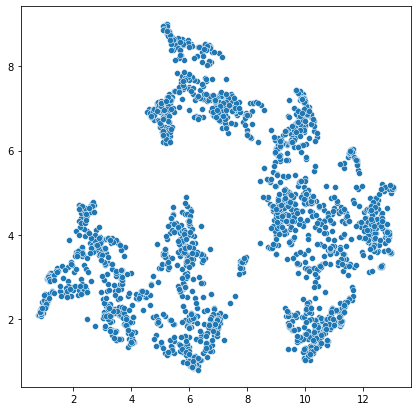

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.show()

In [ ]:
import pandas as pd

topics = []
for t, papers in topics2titles.items():
    for p in papers:
        topics.append(t)

df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "topic": topics})

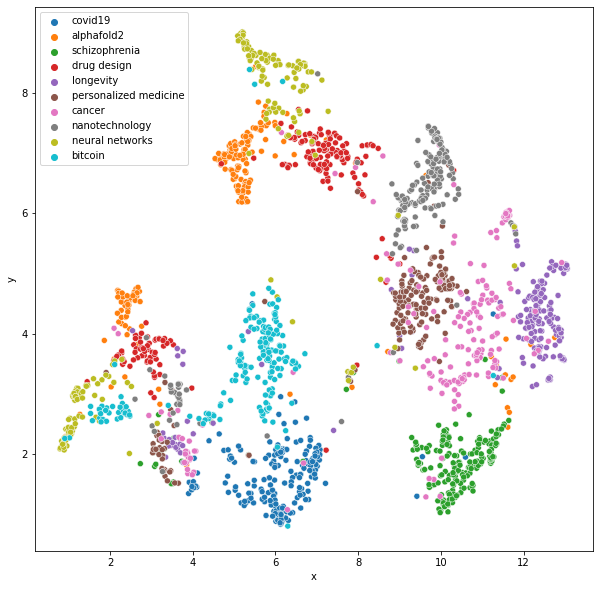

In [ ]:
# Дополните код: замените ??
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue="topic", palette=sns.color_palette("tab10"))
plt.legend()
plt.show()

## Кластеризуем статьи по абстракту 


In [ ]:
def search_papers(query, retmax=200, sort='relevance'):
    Entrez.email = 'pdd@kodomo.fbb.msu.ru'
    handle = Entrez.esearch(db='pubmed',
                            sort=sort,
                            retmax=str(retmax),
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

def check_abstract(ids):
    res = Entrez.esummary(db="pubmed", id=",".join(ids), retmode='xml')
    records = Entrez.parse(res)

    return [rec['Id'] for rec in records if rec['HasAbstract']]


def retrieve_abstracts(query, has_abstract=False, retmax=200, sort='relevance'):
    results = search_papers(query, retmax, sort)
    ids = results['IdList']
    ids = check_abstract(ids)
  
    records = Entrez.read(Entrez.efetch(db="pubmed", id =','.join(ids), rettype="xml"))['PubmedArticle']
    abstracts = []
    for rec in records:
        try:
           abs = rec['MedlineCitation']['Article']['Abstract']['AbstractText']
        except Exception:
            pass
        abs = " ".join(abs)
        abstracts.append(abs)

    return abstracts

In [ ]:
res = retrieve_abstracts("covid19")

In [ ]:
topics = ['covid19',
          'alphafold2',
          'schizophrenia',
          'drug design',
          'longevity',
          'personalized medicine',
          'cancer',
          'nanotechnology',
          'neural networks',
          'bitcoin']

topics2abstracts = {}
for t in topics:
  print(t)
  abstracts = retrieve_abstracts(t)
  topics2abstracts[t] = abstracts

covid19
alphafold2
schizophrenia
drug design
longevity
personalized medicine
cancer
nanotechnology
neural networks
bitcoin


In [ ]:
all_abstracts = sum(topics2abstracts.values(), [])

In [ ]:
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="dmis-lab/biobert-v1.1",
        use_cuda=True
    )
word_vectors = model.encode_sentences(all_abstracts, combine_strategy="mean")
assert word_vectors.shape == (len(all_abstracts), 768) # one sentence embedding per sentence

In [ ]:
umap_trans = UMAP(n_components = 2, metric="cosine")
X = umap_trans.fit_transform(word_vectors)


In [ ]:
topics = []
for t, papers in topics2abstracts.items():
    for p in papers:
        topics.append(t)

df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "topic": topics})

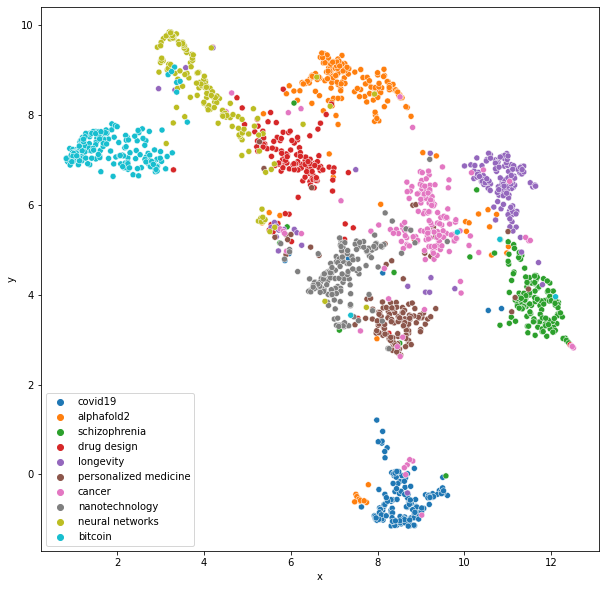

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue="topic", palette=sns.color_palette("tab10"))
plt.legend()
plt.show()

# AlphaFold2 

Ну и, наконец, AlphaFold2. 

Воспользуемся ноутбуком, выложенным в публичный доступ Сергеем Овчинниковым - [ссылка](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)

В этом ноутбуке все полностью автоматизировано 

## Победы AlphaFold2

Не включайте template search, иначе совсем нечестно

In [ ]:
seq1 = "TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEIKTFTVTE"
seq2 = "TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE"

In [ ]:
for ind, (s1, s2) in enumerate(zip(seq1, seq2) ):
  if s1 != s2:
    print(f"Differ: {s1}{ind}{s2}")

Differ: L19A
Differ: I29F
Differ: L44Y


Должно получиться как в [этой статье](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2779201/)

Конечно, можно заметить, что при обучении модель видела структуры, выложенные в PDB. Но у AlphaFold бывают успехи и на структурах, которые еще не были опубликованы и при этом сложны. 

## Поражения AlphaFold2

Промоделируйте следующую последовательность: 



In [ ]:
seq = '''MDQNNSLPPYAQGLASPQGAMTPGIPIFSPMMPYGTGLTPQPIQNTNSLSILEEQQRQQQ
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQAVAAAAVQQSTSQQATQGTSGQAPQ
LFHSQTLTTAPLPGTTPLYPSPMTPMTPITPATPASESSGIVPQLQNIVSTVNLGCKLDL
KTIALRARNAEYNPKRFAAVIMRIREPRTTALIFSSGKMVCTGAKSEEQSRLAARKYARV
VQKLGFPAKFLDFKIQNMVGSCDVKFPIRLEGLVLTHQQFSSYEPELFPGLIYRMIKPRI
VLLIFVSGKVVLTGAKVRAEIYEAFENIYPILKGFRKTT'''

Сравните с тем, что [должно](https://twitter.com/PappulabWashU/status/1418332465740066816/photo/2) получиться 

# *Получаем представления белков 

Кроме этого, есть модели, которые self-supervised натренированы на биологических последовательностях. 

Самая известная из них, разумеется, AlphaFold2, которая тоже внутри себя использует натренированную таким образом подсеть. 

Однако есть и более "простые" модели, например, модель от FacebookAI - ESM1b 

In [ ]:
!pip install fair-esm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.1 MB/s 


In [ ]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm", "esm1b_t33_650M_UR50S")

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


In [ ]:
device = torch.device("cuda")

In [ ]:
import torch
import esm

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.to(device)
batch_converter = alphabet.get_batch_converter()

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEEKALTARQQEVFDLIRDHISQTGMPPTRAEIAQ"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, (_, seq) in enumerate(data):
        sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0).cpu() )


In [ ]:
print(sequence_representations)

In [ ]:
print(sequence_representations[0].shape)

Точно так же, при помощи полученных представлений, белки можно сравнивать. 
Можно использовать полученные представления 

Можем взять несколько семейств белков и посмотреть, разделятся ли они в латентном пространстве. 

А можно попытаться, например, предсказать температуру плавления белка. 

Возьмем датасет, препроцессированный при помощи пакета DeepChem

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/protein_melt.fasta

In [ ]:
!pip install BioPython

In [ ]:
from Bio import SeqIO

In [ ]:
X = []
y = []
for seq in SeqIO.parse("protein_melt.fasta", "fasta"):
    X.append( (seq.id, str(seq.seq)))
    y.append(float(seq.description.split("melt:")[-1]))
    

In [ ]:
X_repr = []

In [ ]:
!nvidia-smi

In [ ]:
step = 1
for ind in range(0, len(X), step):
  print(ind)
  batch_labels, batch_strs, batch_tokens = batch_converter(X[ind:ind+step])

  # Extract per-residue representations (on CPU)
  with torch.no_grad():
      results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
      token_representations = results["representations"][33]
      # Generate per-sequence representations via averaging
      # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
      sequence_representations = []
      for i, (_, seq) in enumerate(X[ind:ind+step]):
          sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0).cpu())
      X_repr.append(sequence_representations)


In [ ]:
X_embed = [x[0].unsqueeze(0) for x in X_repr]

In [ ]:
X_embed = torch.cat(X_embed, dim=0).numpy()

Есть два варианта разбить датасет. Какой правильнее? Указание - посмотрите на идентификаторы последовательностей  

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_embed, y)

In [ ]:
val_start = int(X_embed.shape[0] * (1 - 0.8))
X_train, X_test, y_train, y_test = X_embed[:val_start], X_embed[val_start:], y[:val_start], y[val_start:]

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:
model = SGDRegressor().fit(X_train, y_train)
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"MAE: {mae}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor